<a href="https://colab.research.google.com/github/anosharahim/capstone/blob/master/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import os
import imageio
import numpy as np

In [3]:
#zipped_path = '/content/drive/MyDrive/Capstone/datasets/archive.zip'
#target_path = "/content/drive/MyDrive/Capstone/FER2013'
#unzip and extract files to gdrive
#!unzip zipped_path -d target_path

In [4]:
train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

train_data = []
train_label = []
test_data = []
test_label = []

num_expressions = 6
labels = ['angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [5]:
categories = os.listdir(train_path)

In [6]:
#keep track of y labels 
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}

for emotion in os.listdir(train_path): 
  emotion_label = emotion_dictionary[emotion]
  folder_path = train_path + emotion + '/'
  for image in os.listdir(folder_path):
    image_file = folder_path + image 
    image_array = imageio.imread(image_file) #get image array from file 
    image_array = np.array(image_array.flatten()) #convert to numpy array 
    #add image array and it's label to respective folders 
    train_data.append(image_array)
    train_label.append(emotion_label)

for emotion in os.listdir(test_path): 
  emotion_label = emotion_dictionary[emotion]
  folder_path = test_path + emotion + '/'
  for image in os.listdir(folder_path):
    image_file = folder_path + image 
    image_array = imageio.imread(image_file)
    image_array = np.array(image_array)
    test_data.append(image_array.flatten())
    test_label.append(emotion_label)

#convert x and y to numpy arrays 
train_data = np.array(train_data) 
test_data = np.array(test_data)
train_label = np.array(train_label) 
test_label = np.array(test_label)

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

train_data, train_label = unison_shuffled_copies(train_data, train_label)
test_data, test_label = unison_shuffled_copies(test_data, test_label)

In [8]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(28709, 2304) (28709,)
(7178, 2304) (7178,)


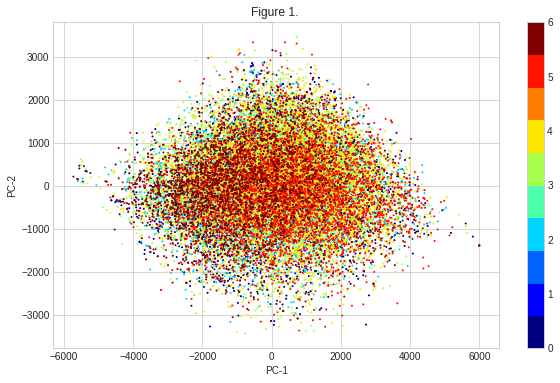

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(2)
pca = pca.fit_transform(train_data)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)

plt.scatter(pca[:, 0], pca[:, 1], s = 1, cmap = c_map , c = train_label) 
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.title('Figure 1. ')
plt.show()

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate=2)
TSNE_features = tsne.fit_transform(pca)





/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


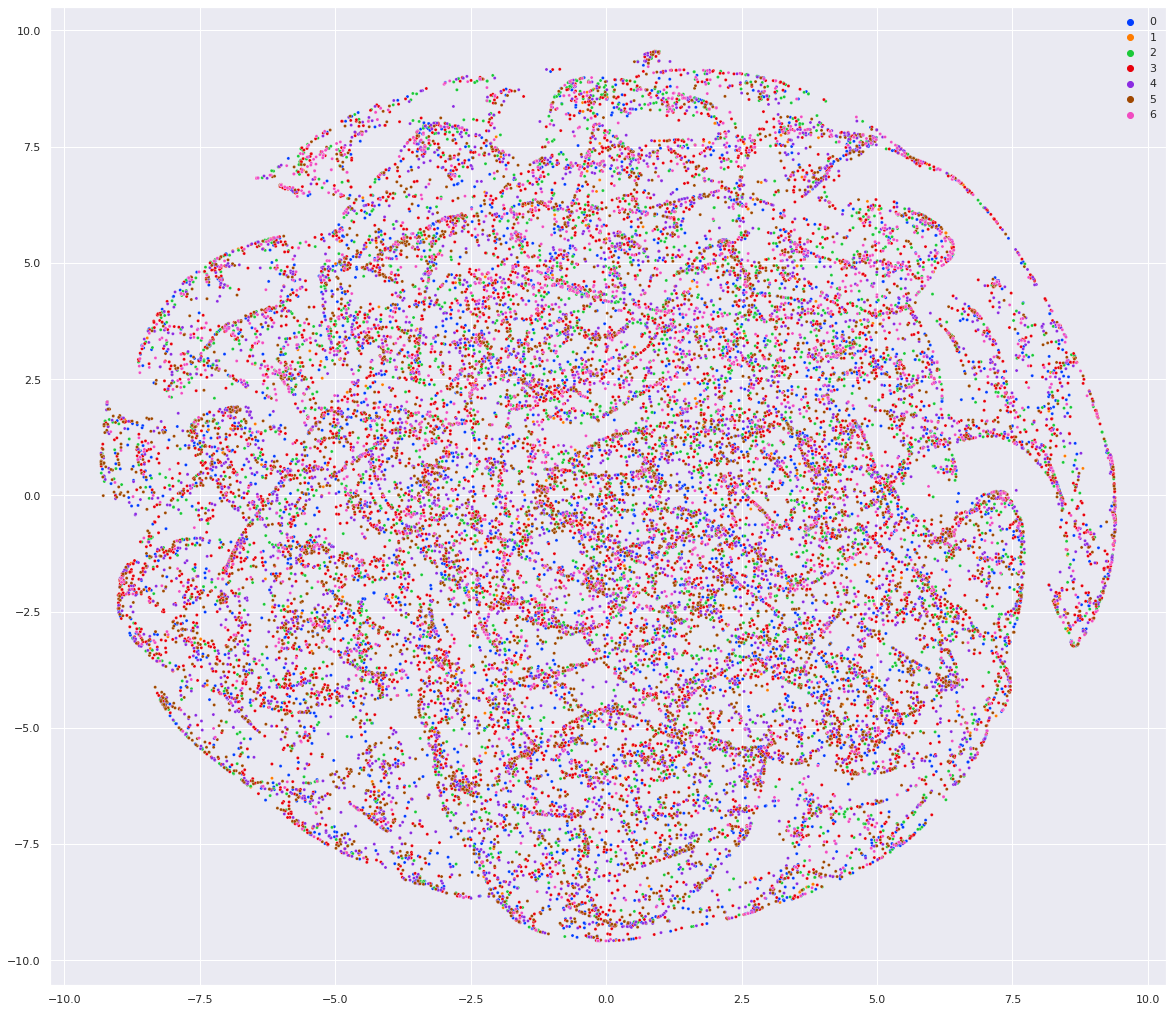

In [32]:
a = TSNE_features[:,0]
b = TSNE_features[:,1]

#sns.set_palette("pastel")
sns.scatterplot(a,b,hue=train_label, legend='full',s=10, palette = 'bright')#, hue=y, legend='full')
sns.set(rc={'figure.figsize':(20,18)})
